# Find curvature tensor for protein from MD


### Steps
1) Fit Fourier surface to simulated membrane
3) Extract local curvature tensor around protein

## Setup

### Imports

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import seaborn as sns
# Extract surface
import glob
import MDAnalysis as mda
from lipyphilic import AssignLeaflets
from scipy.interpolate import griddata
from scipy.optimize import least_squares, minimize

### Import data

In [2]:
# Data options
size = [250, 300, 350, 400, 600, 1000]  # Angstroms
protein = ['Magainin', 'KALP25', 'FAM134B', 'FAM134B2', 'SAR1', 'Influenza', 'Amphiphysin', 'IRSp53', 'Rhodopsin', 'YOP1','ShigaToxin']

# Data choose
file_dir = 'FAM134B_b40'
prot_idx = 3

In [3]:
box_grid = size[prot_idx]  #Angstroms
print('Your grid is: ' f"{box_grid}")
prot_box = f"{protein[2]}_{size[prot_idx]/10}_last_3us"
print('Your system: ' f"{prot_box}")
f_pdb = glob.glob(f'./{file_dir}/production_last.gro')[0]
print('Your gro/pdb: ' f"{f_pdb}")
f_trj = glob.glob(f'./{file_dir}/production_w.xtc')[0] #production_w #production_last_3us
print('Your trajectory: ' f"{f_trj}")

Your grid is: 400
Your system: FAM134B_40.0_last_3us
Your gro/pdb: ./FAM134B_b40/production_last.gro
Your trajectory: ./FAM134B_b40/production_w.xtc


### Define parameters & Import Custom Functions

In [4]:
foldername = 'FAM_b40_nc4_2' # folder name to save files to
os.makedirs(f'./{foldername}', exist_ok=True)

In [7]:
%run curv_funcs.py

Order of Fourier series:  4


## Fit Surface

### Fit Fourier surfaces to MD trajectory

#### Fit Fourier surface to midplane
First find midplane from upper and lower leaflets for each frame, then fit Fourier series

In [8]:
nlastframes = 1500

u_buckle = mda.Universe(f_pdb, f_trj)

upper_surfaces    = []
lower_surfaces    = []
midplane_surfaces = []

Fcoeffs_data = np.zeros((len(u_buckle.trajectory[-nlastframes:]), exp_order*exp_order*4))
Fcoeffs = np.zeros( exp_order*exp_order*4 )  # Define the initial parameters as a 1D array of coefficients
residual_lst = []

for frame_idx, ts in enumerate(u_buckle.trajectory[-nlastframes:]):

    # Assign leaflets
    leaflets = AssignLeaflets(
        universe=u_buckle,
        lipid_sel="name PO4"
    )
    leaflets.run()
    
    u_buckle.trajectory[frame_idx]
    
    phosphates = u_buckle.select_atoms('name PO4')
    pos = phosphates.positions
    leaflet_ids = leaflets.leaflets[:, frame_idx]

    # Box dimensions
    l_x = u_buckle.dimensions[0]
    l_y = u_buckle.dimensions[1]
    
    # Separate upper and lower leaflets
    upper_pos = pos[leaflet_ids == 1]
    lower_pos = pos[leaflet_ids == -1]
    
    # Create 2D grid
    n_bins = 50  # adjust resolution as needed
    x_grid = np.linspace(pos[:, 0].min(), pos[:, 0].max(), n_bins)
    y_grid = np.linspace(pos[:, 1].min(), pos[:, 1].max(), n_bins)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    
    # Interpolate z-positions for each leaflet surface
    upper_surface = griddata(
        upper_pos[:, :2],  # (x, y) coordinates
        upper_pos[:, 2],   # z coordinates
        (X_grid, Y_grid),
        method='cubic')
    
    lower_surface = griddata(
        lower_pos[:, :2],
        lower_pos[:, 2],
        (X_grid, Y_grid),
        method='cubic')
    
    # Calculate midplane surface
    midplane_surface = (upper_surface + lower_surface) / 2 # h_sim

    # Save data
    upper_surfaces    += [upper_surface]
    lower_surfaces    += [lower_surface]
    midplane_surfaces += [midplane_surface]

    # Filter out 'nan' points
    valid_mask = ~np.isnan(midplane_surface)
    # Flatten and filter the arrays
    X_valid = X_grid[valid_mask]
    Y_valid = Y_grid[valid_mask]
    h_sim  = midplane_surface[valid_mask]
    
    # Perform least squares optimization using scipy.optimize
    result = least_squares( calc_residual, Fcoeffs, args=(h_sim, X_valid, Y_valid, l_x, l_y) ) 
    opt_Fcoeffs = result.x  # note: output coeffs as was input - 1D array of length 4 x exp_order x exp_order
    residual_lst += [result.cost]

    # Commit optimised coefficients of trajectory frame 
    Fcoeffs_data[frame_idx] = opt_Fcoeffs
    # Update Fourier coefficients for next guess
    Fcoeffs = opt_Fcoeffs

    # Print progress
    if frame_idx%100==0:
        print(f'Frame {frame_idx}: l_x {l_x} , cost {residual_lst[-1]}')

Frame 0: l_x 421.2791748046875 , cost 2179.7687348054787
Frame 100: l_x 418.80828857421875 , cost 3350.4744473939727


KeyboardInterrupt: 

In [9]:
# Save data
filename = 'mem_profile'
np.savetxt(f'./{foldername}/{filename}.dat', Fcoeffs_data, delimiter='\t', fmt='%0.6f')

# Convert to array
upper_surfaces    = np.array(upper_surfaces)
lower_surfaces    = np.array(lower_surfaces)
midplane_surfaces = np.array(midplane_surfaces) # h_sim

# Take average surface
mean_upper_surface    = np.mean(upper_surfaces, axis=0)
mean_lower_surface    = np.mean(lower_surfaces, axis=0)
mean_midplane_surface = np.mean(midplane_surfaces, axis=0)

print(f"Midplane surfaces shape: {midplane_surfaces.shape}")
print(f"Average midplanes z: {np.nanmean(midplane_surfaces):.2f} Å")

Midplane surfaces shape: (175, 50, 50)
Average midplanes z: 77.50 Å


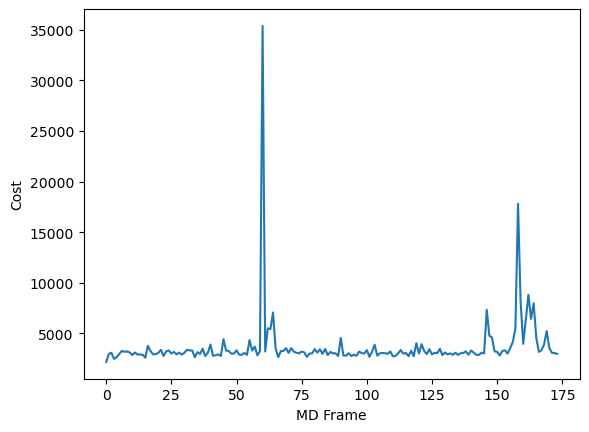

In [10]:
# Plot cost/ residual for each frame

plt.figure()

plt.plot(range(len(residual_lst)), residual_lst)
plt.xlabel('MD Frame')
plt.ylabel('Cost')

plt.savefig(f'./{foldername}/cost.pdf')
plt.show()

### Reconstruct Membrane height and compute curvature

In [11]:
# Input previously computed height coefficients in the form of a .dat file  
Fcoeffs_data = np.genfromtxt(f'./{foldername}/{filename}.dat')

# Input same trajectory gro file and the xtc
#f_pdb = glob.glob('production_last.gro')[0]
#f_trj = glob.glob('production_last-3fr.xtc')[0]
u_buckle = mda.Universe(f_pdb, f_trj)

# Define and initiate the output fields as a function of time/frame/idx
mh_t_data = []
H_t_data  = []
KG_t_data = []
k1_t_data = []
k2_t_data = []

# Make a range of X & Y values to compute functions *** should this be changed to match (moving) membrane? ***
Xr = np.arange(0, box_grid+10, 10)
Yr = np.arange(0, box_grid+10, 10)
# Create a Meshgrid
X, Y = np.meshgrid(Xr, Yr)

for idx, ts in enumerate(u_buckle.trajectory[-nlastframes:]): # [-nlastframes:-nlastframes+<len(midplane_surfaces)>]
    
    # Assign box dimensions from the trajectory
    l_x = ts.dimensions[0]
    l_y = ts.dimensions[1]
    
    # Assign frame number
    hdx = idx #u_buckle.trajectory.frame

    # Take height cofficient matrices from input file
    alpha, beta, gamma, zeta = reformat_Fourier_coeffs( Fcoeffs_data[hdx] )

    # Compute height of membrane
    Z = calc_height(alpha, beta, gamma, zeta, X, Y, l_x, l_y)

    # Compute membrane curvature descriptors...
    # Calculate Fourier coeff derivatives
    h_x, h_y, h_xx, h_xy, h_yy = calc_fourier_derivatives(alpha, beta, gamma, zeta, X, Y, l_x, l_y)
    # Calculate shape operator
    S = calc_shape_operator(h_x, h_y, h_xx, h_xy, h_yy)
    # Calculate curvature descriptors
    G = np.array(calc_curv_descriptors(S))

    # Append the computed field values (as arrays) to the corresponding fields data files
    mh_t_data.append(Z)
    k1_t_data.append(G[0,:])
    k2_t_data.append(G[1,:])
    H_t_data .append(G[2,:])
    KG_t_data.append(G[3,:])

print('Reconstructed')

Reconstructed


In [13]:
np.array(mh_t_data).shape

(175, 41, 41)

In [14]:
# Average fields over the trajectory and reshape it into a 2D array for plotting
av_mh = np.mean(mh_t_data, axis=0).reshape(len(Yr), len(Xr))
av_H  = np.mean(H_t_data, axis=0) .reshape(len(Yr), len(Xr))
av_KG = np.mean(KG_t_data, axis=0).reshape(len(Yr), len(Xr))
av_k1 = np.mean(k1_t_data, axis=0).reshape(len(Yr), len(Xr))
av_k2 = np.mean(k2_t_data, axis=0).reshape(len(Yr), len(Xr))

### Save data

In [15]:
# Save averaged and reshaped curvature field values for plotting
np.save(f'./{foldername}/av_mh_xy_t.npy', mh_t_data)
np.save(f'./{foldername}/av_H_xy_t.npy',  H_t_data)
np.save(f'./{foldername}/av_KG_xy_t.npy', KG_t_data)
np.save(f'./{foldername}/av_k1_xy_t.npy', k1_t_data)
np.save(f'./{foldername}/av_k2_xy_t.npy', k2_t_data)

# Save averaged fields as CSV files
np.savetxt(f'./{foldername}/av_mh.csv', av_mh, delimiter=',')
np.savetxt(f'./{foldername}/av_H.csv', av_H, delimiter=',')
np.savetxt(f'./{foldername}/av_KG.csv', av_KG, delimiter=',')
np.savetxt(f'./{foldername}/av_k1.csv', av_k1, delimiter=',')
np.savetxt(f'./{foldername}/av_k2.csv', av_k2, delimiter=',')

### Visualise

#### Plot Phosphates, midplane and Fourier series
For a chosen frame

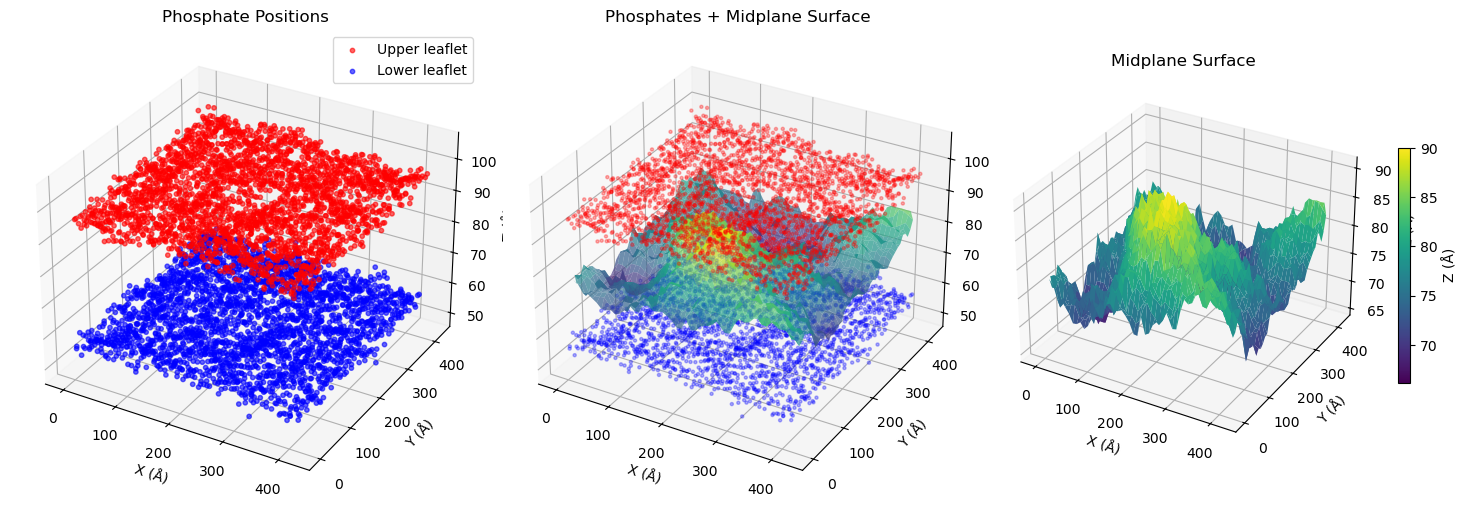

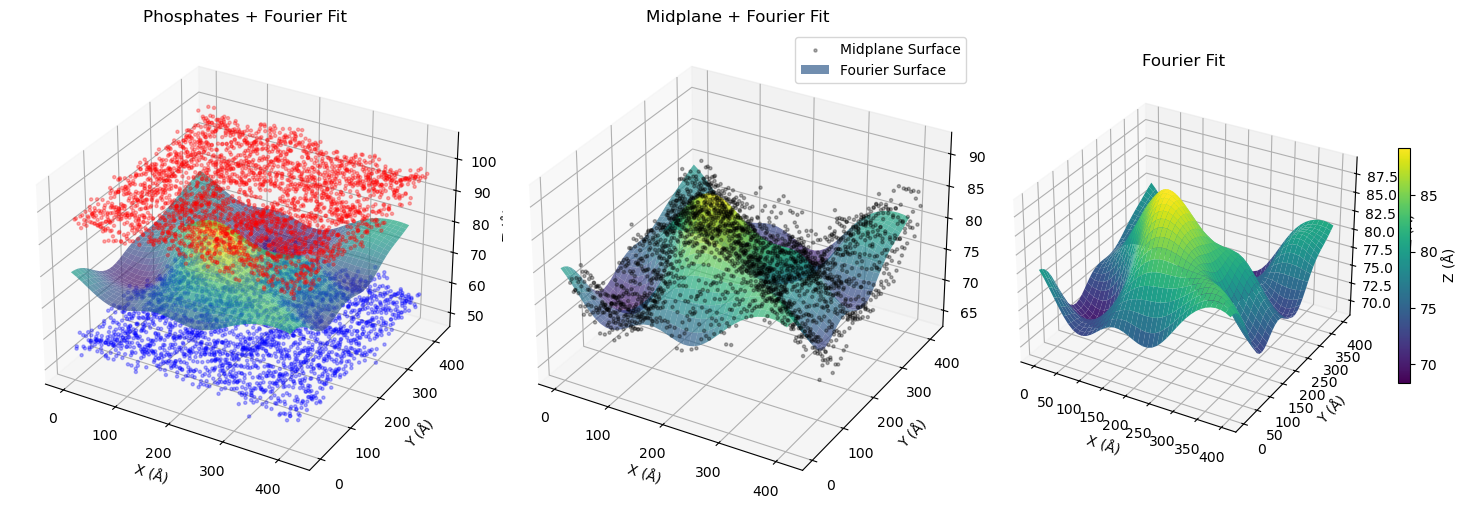

In [19]:
# Select a specific frame
frame_idx = 10


# Get phosphate positions -> grid for midplane surface
phosphates = u_buckle.select_atoms('name PO4')
pos = phosphates.positions
leaflet_ids = leaflets.leaflets[:, frame_idx]
# Separate leaflets
upper_pos = pos[leaflet_ids == 1]
lower_pos = pos[leaflet_ids == -1]
# Create grid for midplane surface
n_bins = 50
x_grid = np.linspace(pos[:, 0].min(), pos[:, 0].max(), n_bins)
y_grid = np.linspace(pos[:, 1].min(), pos[:, 1].max(), n_bins)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# Recall midplane surface
upper_surface    = upper_surfaces[frame_idx]
lower_surface    = lower_surfaces[frame_idx]
midplane_surface = midplane_surfaces[frame_idx]

# Grid for Fourier surface
Xr = np.arange(0, box_grid+10, 10)
Yr = np.arange(0, box_grid+10, 10)
# Create a Meshgrid
X, Y = np.meshgrid(Xr, Yr)

# Recall Fourier fit
Z_fit = mh_t_data[frame_idx]



# Create 3D plot
fig = plt.figure(figsize=(15, 5))

# Plot 1: All phosphates colored by leaflet
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(upper_pos[:, 0], upper_pos[:, 1], upper_pos[:, 2], 
           c='red', s=10, alpha=0.6, label='Upper leaflet')
ax1.scatter(lower_pos[:, 0], lower_pos[:, 1], lower_pos[:, 2], 
           c='blue', s=10, alpha=0.6, label='Lower leaflet')
ax1.set_xlabel('X (Å)')
ax1.set_ylabel('Y (Å)')
ax1.set_zlabel('Z (Å)')
ax1.set_title('Phosphate Positions')
ax1.legend()

# Plot 2: Phosphates with midplane surface
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(upper_pos[:, 0], upper_pos[:, 1], upper_pos[:, 2], 
           c='red', s=5, alpha=0.3)
ax2.scatter(lower_pos[:, 0], lower_pos[:, 1], lower_pos[:, 2], 
           c='blue', s=5, alpha=0.3)
ax2.plot_surface(X_grid, Y_grid, midplane_surface, 
                cmap='viridis', alpha=0.7, edgecolor='none')
ax2.set_xlabel('X (Å)')
ax2.set_ylabel('Y (Å)')
ax2.set_zlabel('Z (Å)')
ax2.set_title('Phosphates + Midplane Surface')

# Plot 3: Just midplane surface (clearer view)
ax3 = fig.add_subplot(133, projection='3d')
surf = ax3.plot_surface(X_grid, Y_grid, midplane_surface, 
                       cmap='viridis', edgecolor='none')
ax3.set_xlabel('X (Å)')
ax3.set_ylabel('Y (Å)')
ax3.set_zlabel('Z (Å)')
ax3.set_title('Midplane Surface')
fig.colorbar(surf, ax=ax3, shrink=0.5, label='Z (Å)')

plt.tight_layout()
plt.savefig(f'./{foldername}/3D_midplane_phos.pdf')
plt.show()


# Create 3D plot
fig = plt.figure(figsize=(15, 5))

# Plot 1: Phosphates with Fourier fit
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(upper_pos[:, 0], upper_pos[:, 1], upper_pos[:, 2], 
           c='red', s=5, alpha=0.3)
ax1.scatter(lower_pos[:, 0], lower_pos[:, 1], lower_pos[:, 2], 
           c='blue', s=5, alpha=0.3)
ax1.plot_surface(X, Y, Z_fit, 
                cmap='viridis', alpha=0.7, edgecolor='none')
ax1.set_xlabel('X (Å)')
ax1.set_ylabel('Y (Å)')
ax1.set_zlabel('Z (Å)')
ax1.set_title('Phosphates + Fourier Fit')

# Plot 2: All phosphates colored by leaflet
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(X_grid, Y_grid, midplane_surface, 
           c='k', s=5, alpha=0.3, label='Midplane Surface')
ax2.plot_surface(X, Y, Z_fit, 
                cmap='viridis', alpha=0.7, edgecolor='none', label='Fourier Surface')
ax2.set_xlabel('X (Å)')
ax2.set_ylabel('Y (Å)')
ax2.set_zlabel('Z (Å)')
ax2.set_title('Midplane + Fourier Fit')
ax2.legend()

# Plot 3: Just midplane surface (clearer view)
ax3 = fig.add_subplot(133, projection='3d')
surf = ax3.plot_surface(X, Y, Z_fit, 
                       cmap='viridis', edgecolor='none')
ax3.set_xlabel('X (Å)')
ax3.set_ylabel('Y (Å)')
ax3.set_zlabel('Z (Å)')
ax3.set_title('Fourier Fit')
fig.colorbar(surf, ax=ax3, shrink=0.5, label='Z (Å)')

plt.tight_layout()
plt.savefig(f'./{foldername}/3D_Fourier_midplane_phos.pdf')
plt.show()

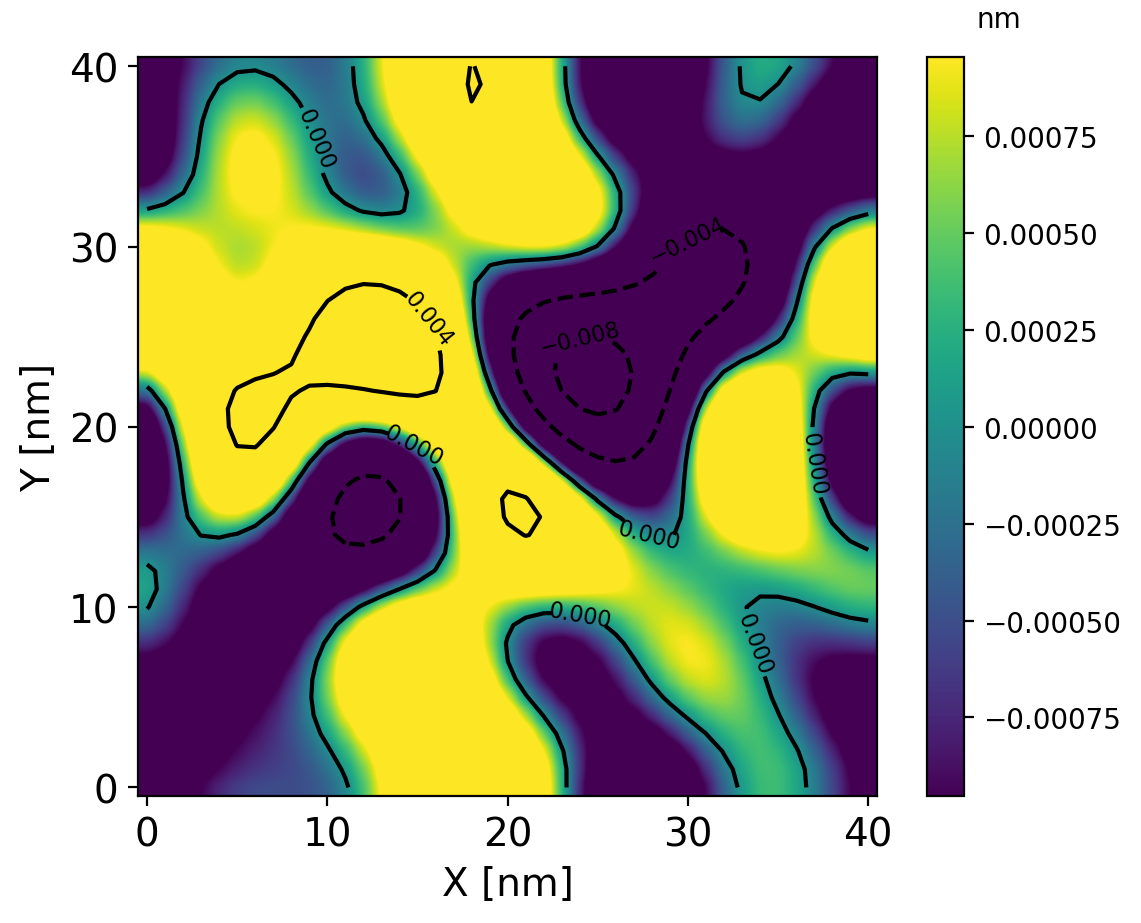

In [20]:
fig, ax = plt.subplots(dpi=200)

# Create contours
contours = ax.contour(av_H * 10, 3, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

# Create the image
maxval = np.max(av_H) if np.max(av_H)>abs(np.min(av_H)) else abs(np.min(av_H))
image = ax.imshow(av_H * 10, origin='lower', cmap='viridis', vmin=-maxval, vmax=maxval, interpolation='Gaussian')
colorbar = plt.colorbar(image, ax=ax)

# Set the ticks and labels
ax.set_xticks(range(0, av_H.shape[1], 10))
ax.set_yticks(range(0, av_H.shape[0], 10))
ax.set_xticklabels(range(0, av_H.shape[1], 10), fontsize=14)
ax.set_yticklabels(range(0, av_H.shape[0], 10), fontsize=14)

# Set labels
ax.set_xlabel('X [nm]', fontsize=14)
ax.set_ylabel('Y [nm]', fontsize=14)

# Set colorbar label
colorbar.set_label('nm', rotation=0, labelpad=-44, y=1.07, x=-1)

# Save the figure

pdf = '_H_xy.pdf'
png = '_H_xy.png'
plt.savefig(f'./{foldername}/{prot_box}{pdf}', bbox_inches='tight')
plt.savefig(f'./{foldername}/{prot_box}{png}', bbox_inches='tight')
plt.show()

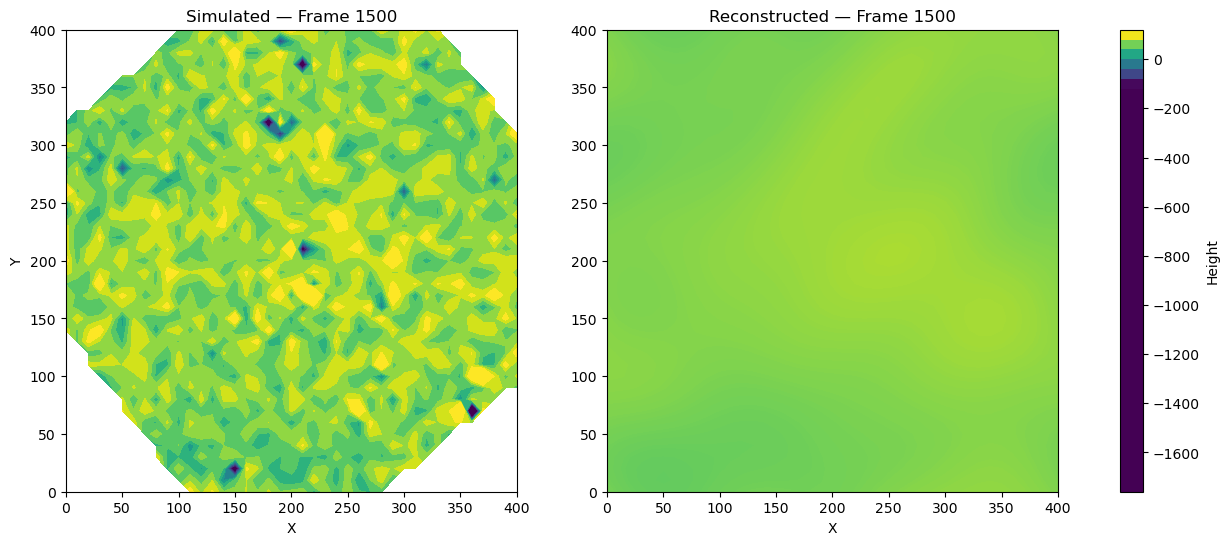

In [13]:
# True height
Z_sim = []
for frame_idx, ts in enumerate(u_buckle.trajectory[:]):
    u_buckle.trajectory[frame_idx]
    # Get phosphate positions
    phosphates = u_buckle.select_atoms('name PO4')
    pos = phosphates.positions
    leaflet_ids = leaflets.leaflets[:, frame_idx]
    
    # Separate leaflets
    upper_pos = pos[leaflet_ids == 1]
    lower_pos = pos[leaflet_ids == -1]

    # Box dimensions
    l_x = u_buckle.dimensions[0]
    l_y = u_buckle.dimensions[1]
    
    # Create grid for midplane surface
    n_bins = 50
    x_grid = np.linspace(pos[:, 0].min(), pos[:, 0].max(), n_bins)
    y_grid = np.linspace(pos[:, 1].min(), pos[:, 1].max(), n_bins)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    
    # Calculate midplane surface
    upper_surface = griddata(upper_pos[:, :2], upper_pos[:, 2], 
                            (X_grid, Y_grid), method='linear')
    lower_surface = griddata(lower_pos[:, :2], lower_pos[:, 2], 
                            (X_grid, Y_grid), method='linear')
    midplane_surface = (upper_surface + lower_surface) / 2
    Z_sim.append(z_grid)

# Visualise w/ contour plot
visualise(Fcoeffs_data, X_grid, Y_grid, Z_sim l_x, l_y, foldername)

## Curvature Around Protein

### Additional functions

In [21]:
# extra functions not yet defined in curv_funcs.py ...

def be_xy(alpha, beta, gamma, zeta, X, Y, l_x, l_y, p_com, pv, t):
    '''
    Put all functions together for objective function calculation in minimisation step

    INPUT
    alpha : ndarray, Fourier series coefficient, exp_order square matrix
    beta  : ndarray, Fourier series coefficient, exp_order square matrix
    gamma : ndarray, Fourier series coefficient, exp_order square matrix
    zeta  : ndarray, Fourier series coefficient, exp_order square matrix
    X     : ndarray, x-position
    Y     : ndarray, y-position
    l_x   : float, length of simulation box in X-axis
    l_y   : float, length of simulation box in Y-axis
    p_com : ndarray, protein centre of mass (com)
    pv    : ndarray, protein principle axis vector
    t     : ndarray, protein curvature tensor, to be optimised

    OUTPUT
    be    : ndarray, function of curvature field (multiD), precurser to objective function output (1D)
    '''
    # Calculate Fourier coeff derivatives
    h_x, h_y, h_xx, h_xy, h_yy = calc_fourier_derivatives(alpha, beta, gamma, zeta, X, Y, l_x, l_y)

    # Calculate area element
    dA = calc_area_element(h_x, h_y)

    # Calc shape operator
    S = calc_shape_operator(h_x, h_y, h_xx, h_xy, h_yy)

    # Calculate curvature descriptors and principle curvatures
    #H, K_G, k1, k2 = calc_curv_descriptors(S) # principle curvatures 
    H, K_G, k1, k2, theta1, theta2 = calc_curv_descriptors_full(S) # principle curvatures *** does this give same results?

    # Calculate mean curvature tensor
    M = calc_mean_curv_tensor(k1, k2, theta1) # *** is there a difference between using either theta?
    
    # Calculate angle (phi) between flat plane (ux) and protein principle axis (pv)
    ux  = np.array([1, 0])   
    phi = calc_angle(ux, pv) 

    # Calculate spontaneous curvature tensor
    C0 = calc_spont_curv_tensor(t, phi) 
    
    # Calculate weight function
    wf = calc_wf(X, Y, p_com, t) 

    # Result
    be = ((M - (C0*wf))**2).sum()*dA

    return be


def tbe_g(t):
    '''
    Minimise parameter t for protein local curvature field

    INPUT
    t : ndarray, protein curvature tensor

    OUTPUT
    obj_out : float, loss - objective function output for curvature tensor t
    '''
    # Define space grid
    delta=10
    Xr = np.arange(0, l_x, delta)
    Yr = np.arange(0, l_y, delta)
    X, Y = np.meshgrid(Xr, Yr)
    
    # Calculate protein curvatures
    be_G = np.array([be_xy(alpha, beta, gamma, zeta, Xr, Yr, l_x, l_y, p_com, pv, t) for Xr,Yr in zip(np.ravel(X), np.ravel(Y))])

    # Sum together
    obj_out = be_G.sum()*10*delta**2
    
    return obj_out


# For protein position axis??

##Define principal curvatures
def prin_ax(coord):
    # compute geometric center
    center = np.mean(coord, 0)
    # center with geometric center
    coord = coord - center
    # compute principal axis matrix
    inertia = np.dot(coord.transpose(), coord)
    e_values, e_vectors = np.linalg.eig(inertia)
    order = np.argsort(e_values)
    eval3, eval2, eval1 = e_values[order]
    axis3, axis2, axis1 = e_vectors[:, order].transpose()
    return [axis1, axis2, axis3]

### Minimisation/ extract curvature tensor

In [23]:
# Input previously computed height coefficients in the form of a .dat file  
Fcoeffs_data = np.genfromtxt(f'./{foldername}/{filename}.dat')

# Set initial params
data=np.zeros((len(u_buckle.trajectory), 7))
# hcf0 = np.ones(exp_order*exp_order*4) # -- not used?
# Initial guess
t0 = [-7.33963762e-04, 3.66333870e-04, 8.72761053e+01]

# Track successful minimisation convergence
nconverged = 0
nconverged_track = []

# Table header for prints
log_statement = f"{'frame':<8} {'nconverged':<12} {'time':<12} {'hdx':<12} {'obj_func(t)':<12} {'iters':<8} {' tensor x':<15} {'tensor y':<15} {'tensor z':<15}\n{'-'*111}"
print(log_statement)
log_txt = log_statement+'\n'

# Minimise dumped frames from trajectory
for idx, ts in enumerate(u_buckle.trajectory):

    # Assign box dimensions from the trajectory
    l_x = ts.dimensions[0]
    l_y = ts.dimensions[1]

    # Assign frame number
    hdx = idx #u_buckle.trajectory.frame # -- .frame always 0?
    
    # Defining Protein props
    prot = u_buckle.atoms.select_atoms('name BB')
    
    # Protein COM position
    p_com = [prot.center_of_mass()[0], prot.center_of_mass()[1]]
    
    # Protein principal axis orientation along x and y
    pv = [prot.principal_axes()[0][0], prot.principal_axes()[0][1]]

    # Take height cofficient matrices from input file
    alpha, beta, gamma, zeta = reformat_Fourier_coeffs( Fcoeffs_data[hdx] )
    #hcf0 = Fcoeffs_data[hdx] # -- not used?

    # Note: following parameters have been assigned for use in be_xy w/in tbe_g ...
    # alpha, beta, gamma, zeta, X, Y, l_x, l_y, p_com, pv
    
    # Minimisation
    res = minimize(tbe_g, t0, method='L-BFGS-B')

    # Update initial guess & data output
    t0  = res.x
    data[idx] = [u_buckle.trajectory.time, hdx, res.fun, res.nit, res.x[0], res.x[1], res.x[2]]

    # Track convergence
    nconverged += 1 if res.success else 0
    nconverged_track += [nconverged]
    if not res.success:
        print(res.status)

    # Print & save updates
    if idx%50==0 and idx!=0:
        # Print updates and save to log file
        log_statement = f"{idx:<8} {nconverged:<12} {float(data[idx][0]):<12.2e} {float(data[idx][1]):<12.2e} {float(data[idx][2]):<12.6f} {float(data[idx][3]):<8.0f} {float(data[idx][4]):<15.6e} {float(data[idx][5]):<15.6e} {float(data[idx][6]):<15.2f}"
        print(log_statement)
        log_txt += log_statement + '\n'

        np.savetxt(f'./{foldername}/t1_t2_sig.dat', data, delimiter='\t', fmt='%0.6f')

# Save data
np.savetxt(f'./{foldername}/t1_t2_sig.dat', data, delimiter='\t', fmt='%0.6f')

# Write to log file
with open(f'./{foldername}/min_log.txt', 'w') as f:
    f.write(log_txt)

frame    nconverged   time         hdx          obj_func(t)  iters     tensor x       tensor y        tensor z       
---------------------------------------------------------------------------------------------------------------
50       51           1.00e+05     5.00e+01     3.508514     3        -1.159339e-04   -1.591403e-04   3612.24        
100      101          2.00e+05     1.00e+02     2.164091     3        -1.020645e-04   -1.035026e-04   3612.24        
150      151          3.00e+05     1.50e+02     2.972706     3        -1.453209e-04   -2.096648e-04   3612.24        


KeyboardInterrupt: 

In [ ]:
# Check both methods give same shared results

h_x, h_y, h_xx, h_xy, h_yy = calc_fourier_derivatives(alpha, beta, gamma, zeta, X, Y, l_x, l_y)

# Calc shape operator
S = calc_shape_operator(h_x, h_y, h_xx, h_xy, h_yy)

G_short = calc_curv_descriptors(S)

G_fulls = calc_curv_descriptors_full(S)

### Plots

In [ ]:
np.histogram(data[:, 6])

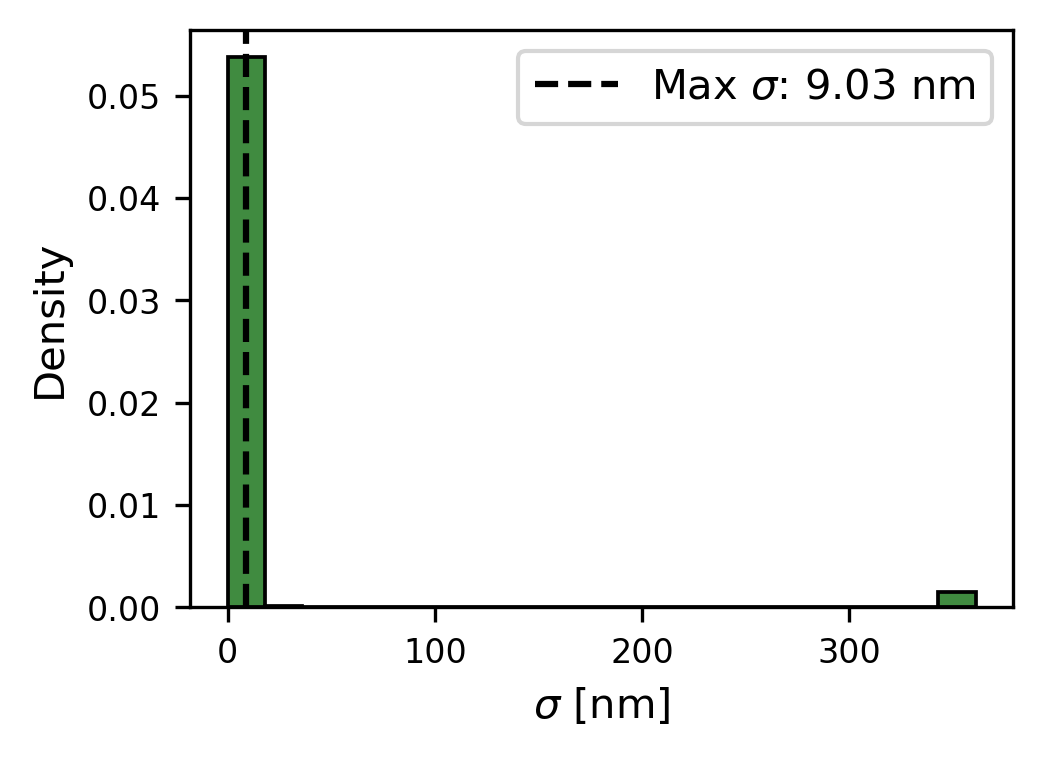

In [25]:
data = np.loadtxt(f'./{foldername}/t1_t2_sig.dat')

sigma_values = np.abs(data[:, 6]/10)

fig = plt.figure(figsize=(3.54, 2.5), dpi=300)

ax = sns.histplot(sigma_values, bins=20, color='darkgreen', kde=False, 
                  edgecolor='black', stat="density")

# Find the bin with the maximum frequency (maximum of distribution)
counts, bin_edges = np.histogram(sigma_values, bins=20)
max_bin_index = np.argmax(counts)  # Find the index of the bin with the maximum count
max_bin_center = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2  # Center of the bin

plt.axvline(max_bin_center, color='black', linestyle='--', label=f'Max $\sigma$: {max_bin_center:.2f} nm')

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax.set_xlabel('$\sigma$ [nm]', fontsize=10)
ax.set_ylabel('Density', fontsize=10)

plt.legend()
fig.savefig(f'./{foldername}/sigma_plot_with_max.pdf', bbox_inches='tight')

plt.show()

ValueError: Contour levels must be increasing

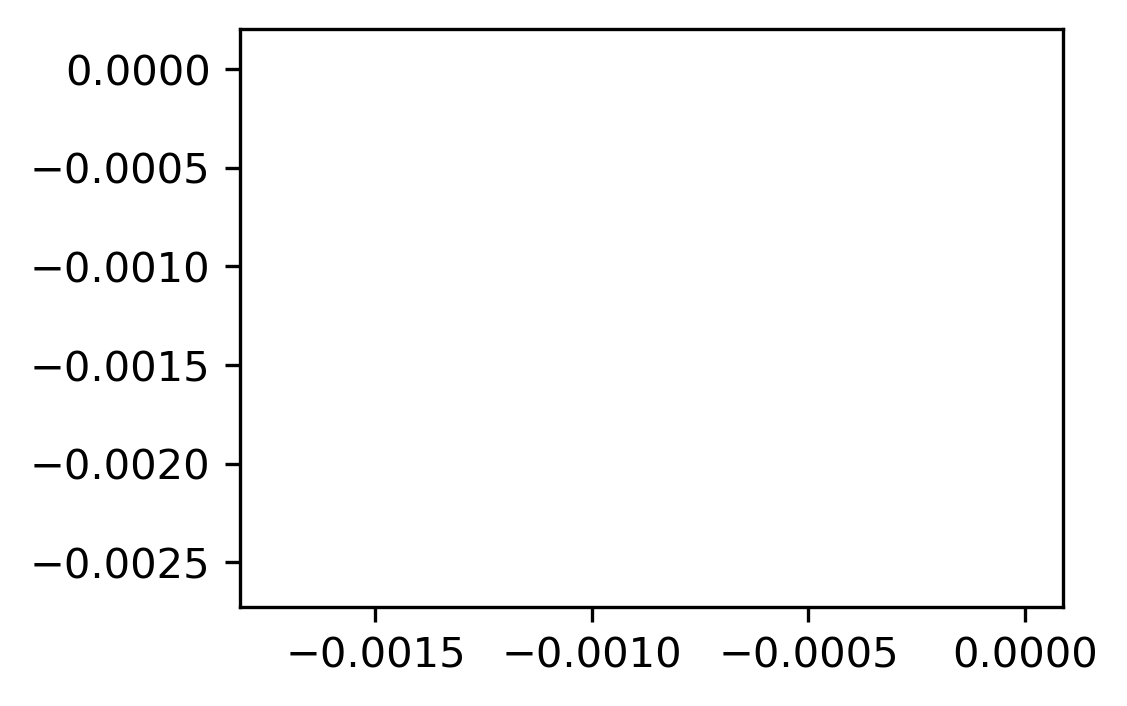

In [27]:
data = np.loadtxt(f'./{foldername}/t1_t2_sig.dat')

# Extract t1 (column 4) and t2 (column 5) values
t1_values = data[:, 4]
t2_values = data[:, 5]

# Create the figure with given size and resolution
fig = plt.figure(figsize=(3.54, 2.5), dpi=300)

# Create a scatter plot with seaborn (with reduced point size and added transparency)
ax = sns.scatterplot(x=t1_values, y=t2_values, color='green', s=15, alpha=0, edgecolor='black')
sns.kdeplot(x=t1_values, y=t2_values, ax=ax, cmap="Greens", fill=True)

ax.axhline(0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(0, color='grey', linestyle='--', linewidth=0.5)
# Customize axis labels and ticks
ax.set_xlabel('$t_1$', fontsize=10)
ax.set_ylabel('$t_2$', fontsize=10)
ax.set_xlim(-0.025, 0.025)
ax.set_ylim(-0.025, 0.025)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Save the figure to a file
fig.savefig(f'./{foldername}/t1_vs_t2_plot_adjusted.pdf', bbox_inches='tight')

# Display the plot
plt.show()

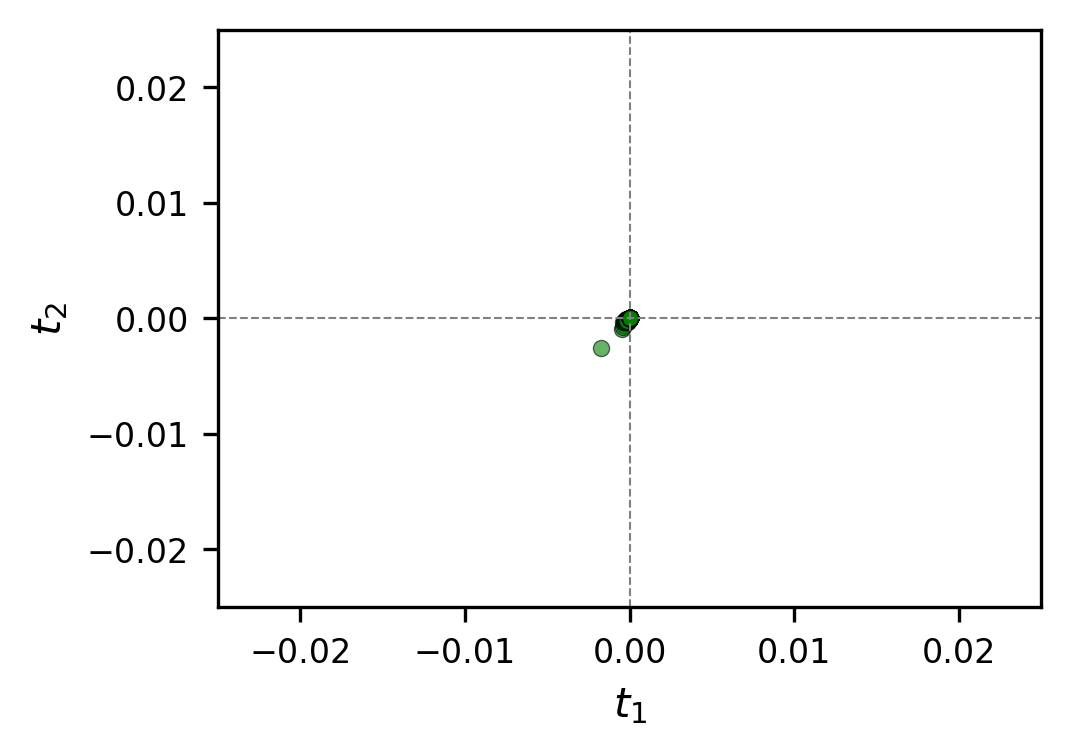

In [28]:
data = np.loadtxt(f'./{foldername}/t1_t2_sig.dat')

# Extract t1 (column 4) and t2 (column 5) values
t1_values = data[:, 4]
t2_values = data[:, 5]

# Create the figure with given size and resolution
fig = plt.figure(figsize=(3.54, 2.5), dpi=300)

# Create a scatter plot with seaborn (with reduced point size and added transparency)
ax = sns.scatterplot(x=t1_values, y=t2_values, color='green', s=15, alpha=0.6, edgecolor='black')
# sns.kdeplot(x=t1_values, y=t2_values, ax=ax, cmap="Greens", fill=True)

ax.axhline(0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(0, color='grey', linestyle='--', linewidth=0.5)
# Customize axis labels and ticks
ax.set_xlabel('$t_1$', fontsize=10)
ax.set_ylabel('$t_2$', fontsize=10)
ax.set_xlim(-0.025, 0.025)
ax.set_ylim(-0.025, 0.025)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Save the figure to a file
fig.savefig(f'./{foldername}/t1_vs_t2_plot_scatter.pdf', bbox_inches='tight')

# Display the plot
plt.show()